# PYTORCH COMPUTER VISION

## 0. Computer vision libraries for Pytorch

* [`torchvision`]
* `torchvision.datasets`
* `torchvision.models`
* `torchvision.transforms`
* `torchvision.utils.data.Dataset`
* `torchvision.utils.data.DataLoader`

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


## 1. Getting a dataset

FashinMNIST will be the dataset used, downloaded from torchvision.datasets.

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
image, label = train_data[0]

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [8]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label : {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label : Ankle boot


### 1.2 Visualising our data

Image shape: torch.Size([1, 28, 28])


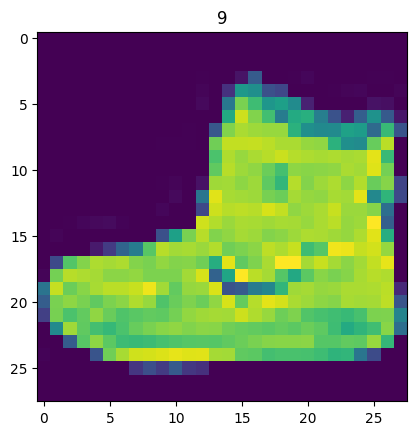

In [9]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())
plt.title(label);

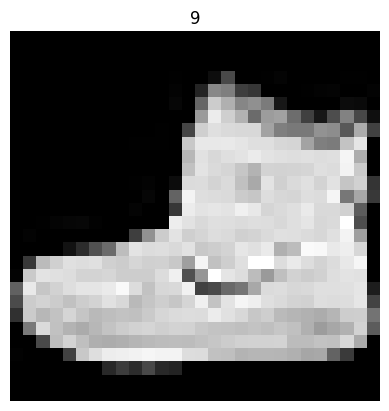

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label);
plt.axis(False);

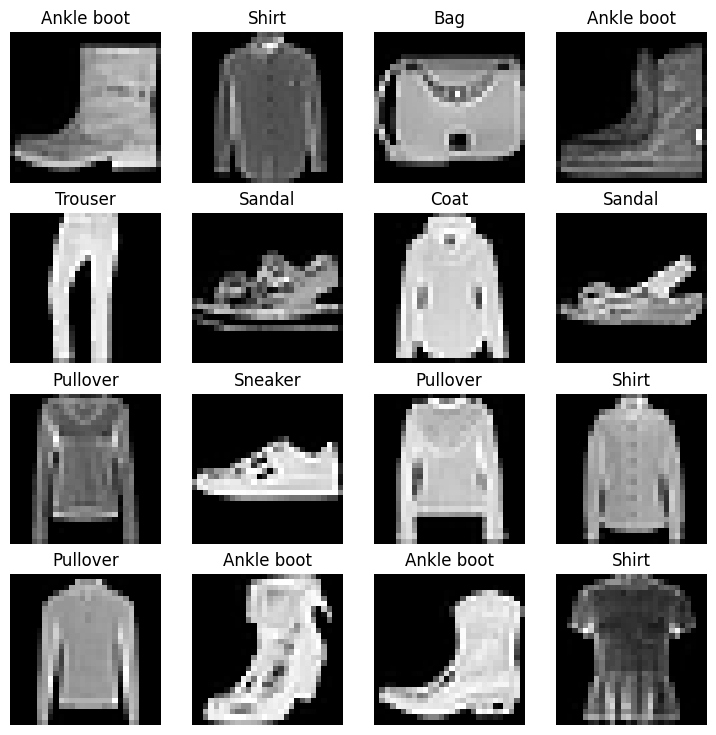

In [11]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False);

¿Estos items pueden ser modelados con lineas o deben tratarse con no lineales?

In [12]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Our data is in form of pytorch datasets. Dataloader turns oyut dataset into a python iterable. We wanna turn our data into batches (or mini-batches). Why?

- More computationally efficient. Break down to 32 images at a time (batch size of 32).
- More chances to our nn to update its gradients per epoch.


In [13]:
from torch.utils.data import DataLoader

# Setup batch size hyperparameter
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78cdae89bbe0>,
 <torch.utils.data.dataloader.DataLoader at 0x78cdaeebf340>)

In [14]:
# Check out what we created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Lenght of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Lenght of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x78cdae89bbe0>, <torch.utils.data.dataloader.DataLoader object at 0x78cdaeebf340>)
Lenght of train dataloader: 1875 batches of 32
Lenght of test dataloader: 313 batches of 32


In [15]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

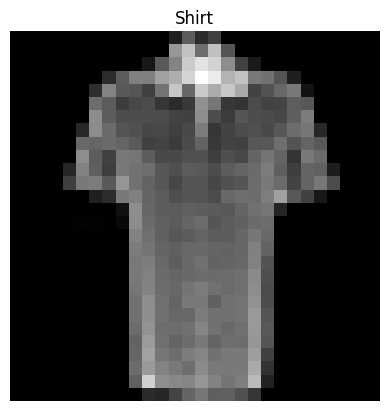

In [16]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)


## 3. Model 0: Build a baseline model

When building a ML model, it's best practise to start with a baseline model, a smiple model you will try to improve upon subsequent experiments.

In [17]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a simple sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [18]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [19]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [21]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

We will use helper_functions.py and subsequently accuracy_fn() defined in notebook 02 since we are working on a classification problem.

* Loss function: `nn.CrossEntropyLoss()`.
* Optimizer: `torch.optim.SGD`.


We could also import evaluation metrics from the TorchMetrics package.

In [22]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [23]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Create a function to time out experiments

We wanna track two things:
- Our model's performance (loss and accuracy values etc.).
- How fast it runs.

In [24]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time


In [25]:
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time, device="cpu")

Train time on cpu: 0.000 seconds


5.124599999817292e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss per batch.
3. Loop through testing batches, perform testing steps, calculate the test loss per batch.
4. Print what's happening.
5. Time it all.

In [26]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")
  # Training
  train_loss = 0
  # Add a loop to loop through training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()
    # 1. Forward pass
    y_pred = model_0(X)
    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    # Print what's happening
    if batch % 400 == 0:
      print(f"Looked at batch {batch * len(X)}/{len(train_dataloader.dataset)} sampled.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)
      # 2. Calculate the loss
      test_loss += loss_fn(test_pred, y_test)
      # 3. Calculate the accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))
    # Calculate the test losss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test accuracy per batch
    test_acc /= len(test_dataloader)

  # Print what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss : {test_loss:.4f} | Test acc: {test_acc:.4f}")

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters())))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at batch 0/60000 sampled.
Looked at batch 12800/60000 sampled.
Looked at batch 25600/60000 sampled.
Looked at batch 38400/60000 sampled.
Looked at batch 51200/60000 sampled.

Train loss: 0.5904 | Test loss : 0.5095 | Test acc: 82.0387
Epoch: 1
-----
Looked at batch 0/60000 sampled.
Looked at batch 12800/60000 sampled.
Looked at batch 25600/60000 sampled.
Looked at batch 38400/60000 sampled.
Looked at batch 51200/60000 sampled.

Train loss: 0.4763 | Test loss : 0.4799 | Test acc: 83.1969
Epoch: 2
-----
Looked at batch 0/60000 sampled.
Looked at batch 12800/60000 sampled.
Looked at batch 25600/60000 sampled.
Looked at batch 38400/60000 sampled.
Looked at batch 51200/60000 sampled.

Train loss: 0.4550 | Test loss : 0.4766 | Test acc: 83.4265
Train time on Parameter containing:
tensor([[ 0.0273,  0.0298, -0.0065,  ...,  0.0071,  0.0091,  0.0170],
        [-0.0189, -0.0355,  0.0155,  ...,  0.0161,  0.0120,  0.0117],
        [-0.0008,  0.0020,  0.0032,  ...,  0.0058, -0

In [27]:
str(next(model_0.parameters()).device)

'cpu'

## 4. Make predictions and get Model 0 results

In [119]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [121]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device=device,
               accuracy_fn=accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make our data device agnostic
      X, y = X.to(device), y.to(device)
      # Make predictions
      y_pred = model(X)
      # Accumulate loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
      # Scale loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (using GPU if available)

In [30]:
torch.cuda.is_available()

True

In [31]:
# Setup device-agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: building a better model with non-linearity



In [32]:
# Create a model with linear and non linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x:torch.Tensor):
    return self.layer_stack(x)


In [33]:
# Instantiate model 1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, opimizer and evaluation metrics

In [34]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [91]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [92]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a tesing loop step on model going over data_loader"""
  test_loss, test_acc = 0, 0

  # Put model into eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss/acc
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # Go from logits to prediction labels

    # adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss : {test_loss:.4f} | Test acc: {test_acc:.2f} %")



In [37]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epoch
epochs = 3

# Optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epochs: {epoch}")
  train_step(model=model_1,
             data_loader=train_dataloader,
             optimizer=optimizer,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

  test_step(model=model_1,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epochs: 0
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss : 0.9564 | Test acc: 65.00 %
Epochs: 1
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss : 0.7223 | Test acc: 73.91 %
Epochs: 2
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss : 0.6850 | Test acc: 75.02 %
Train time on cuda: 37.467 seconds


In [38]:
total_train_time_model_1

37.46666529899994

*Note*: Depending on data/hardware, model may train faster on cpu than gpu.

1. It could be that the overhead for copying data/model to and from the GPU outweights the compute benefits offerred by the GPU.
2. The hardware has a better CPU in terms of compute capability than GPU.

In [39]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [40]:
# model_0_results

## Model 2: Building a Convolutional Neural Network CNN

Recreate the next architectures: https://github.com/poloclub/cnn-explainer

In [93]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [69]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # black and white images
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

In [70]:
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 7.1 Stepping through nn.Conv2d()

In [71]:
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single batch shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single batch shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0

In [73]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

### 7.2 Stepping through a `nn.MaxPool2d()`.

In [74]:
test_image.shape

torch.Size([3, 64, 64])

In [75]:
# Print out original image shape without unsqueezed dimensions
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed shape: {test_image.unsqueeze(0).shape}")

# Create a sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv layer
test_image_through_conv_layer = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv layer: {test_image_through_conv_layer.shape}")

# Pass data through just the pool layer
test_image_through_conv_and_max_layer = max_pool_layer(test_image_through_conv_layer)
print(f"Shape after going through conv layer and max pool layer: {test_image_through_conv_and_max_layer.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed shape: torch.Size([1, 3, 64, 64])
Shape after going through conv layer: torch.Size([1, 10, 62, 62])
Shape after going through conv layer and max pool layer: torch.Size([1, 10, 31, 31])


In [76]:
torch.manual_seed(42)
# Create a random tensor with a similar number of dimensions
random_tensor = torch.randn(size=(1,1,2,2))

# Create a maxpool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass the random tensor through the layer
max_pool_tensor = max_pool_layer(random_tensor)

print(f"Random tensor components: {random_tensor} and shape: {random_tensor.shape}")
print(f"Random tensor after Max Pool components: {max_pool_tensor} and shape: {max_pool_tensor.shape}")

Random tensor components: tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]]) and shape: torch.Size([1, 1, 2, 2])
Random tensor after Max Pool components: tensor([[[[0.3367]]]]) and shape: torch.Size([1, 1, 1, 1])


In [106]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)


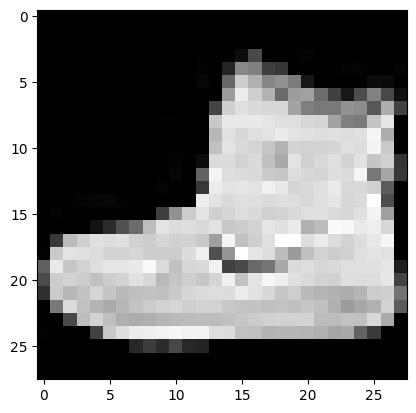

In [107]:
plt.imshow(image.squeeze(), cmap="gray")

In [108]:
rand_image_tensor = torch.randn(size=(1, 28, 28))
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [109]:
# Pass image through model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [110]:
# Pass image through model
model_2(image.unsqueeze(0).to(device))

tensor([[ 0.0246, -0.0644,  0.0551, -0.0360, -0.0139,  0.0113, -0.0014, -0.0075,
          0.0213,  0.0076]], device='cuda:0', grad_fn=<AddmmBackward0>)

### 7.3 Setup a loss function and optimizer for `model_2`

In [111]:
# Setup loss funcion/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.1)

### 7.4 Training and testing ´model_2´ using our training and test functions

In [112]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.58750 | Train accuracy: 78.69%
Test loss : 0.3899 | Test acc: 86.13 %
Epoch: 1
---------
Train loss: 0.36207 | Train accuracy: 86.96%
Test loss : 0.3472 | Test acc: 87.27 %
Epoch: 2
---------
Train loss: 0.32432 | Train accuracy: 88.29%
Test loss : 0.3159 | Test acc: 88.71 %
Train time on cuda: 38.973 seconds


In [114]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    device=device,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31588950753211975,
 'model_acc': 88.70806709265176}

## 8. Compare model results and training time

We've trained three different models.

- `model_0` - our baseline model with two nn.Linear() layers.
- `model_1` - the same setup as our baseline model except with nn.ReLU() layers in between the nn.Linear() layers.
- `model_2` - our first CNN model that mimics the TinyVGG architecture on the CNN Explainer website.
This is a regular practice in machine learning.

Building multiple models and performing multiple training experiments to see which performs best.

Let's combine our model results dictionaries into a DataFrame and find out.

In [115]:
import pandas as pd

In [123]:
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])

compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.315890,88.708067


In [124]:
# Add training time to results dataframe
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,56.747111
1,FashionMNISTModelV1,0.685001,75.019968,37.466665
2,FashionMNISTModelV2,0.315890,88.708067,38.972525


Performance-speed tradeoff

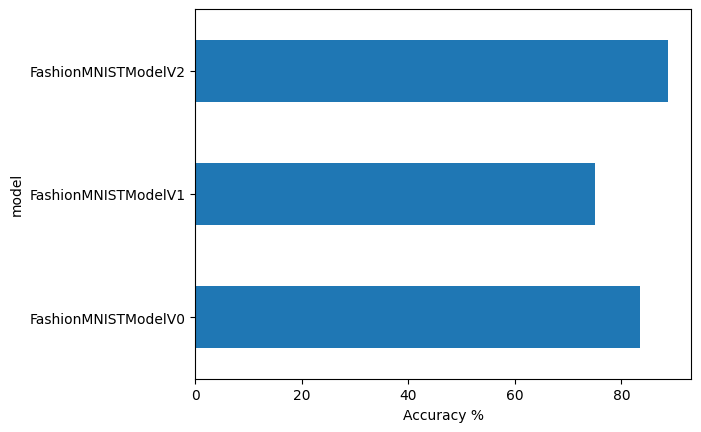

In [126]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("Accuracy %")
plt.ylabel("model");

## 9. Make and evaluate random predictions with best model

In [129]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device=device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_probs off the GPU for further calculations
      pred_probs.append(pred_prob)

  # Stack the pred_probs to turn list into a tensor (matplotlib (doesn`t work on GPU))
  return torch.stack(pred_probs)

In [132]:
img, label = test_data[0][:10]
img.shape, label

(torch.Size([1, 28, 28]), 9)

In [134]:
import random
random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# view the sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

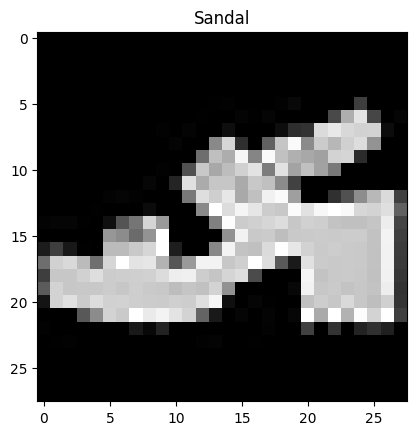

In [138]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]]);

In [140]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View the first two predictions probabilities
pred_probs[:2]

tensor([[1.4536e-07, 1.7057e-08, 5.5118e-08, 2.1254e-07, 1.1888e-08, 9.9993e-01,
         1.4126e-07, 5.5986e-06, 2.2759e-05, 3.6762e-05],
        [2.9321e-02, 4.1365e-01, 1.6222e-03, 2.7701e-01, 1.0823e-01, 1.9338e-04,
         1.6733e-01, 3.7166e-04, 1.8168e-03, 4.5769e-04]], device='cuda:0')

In [141]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1], device='cuda:0')

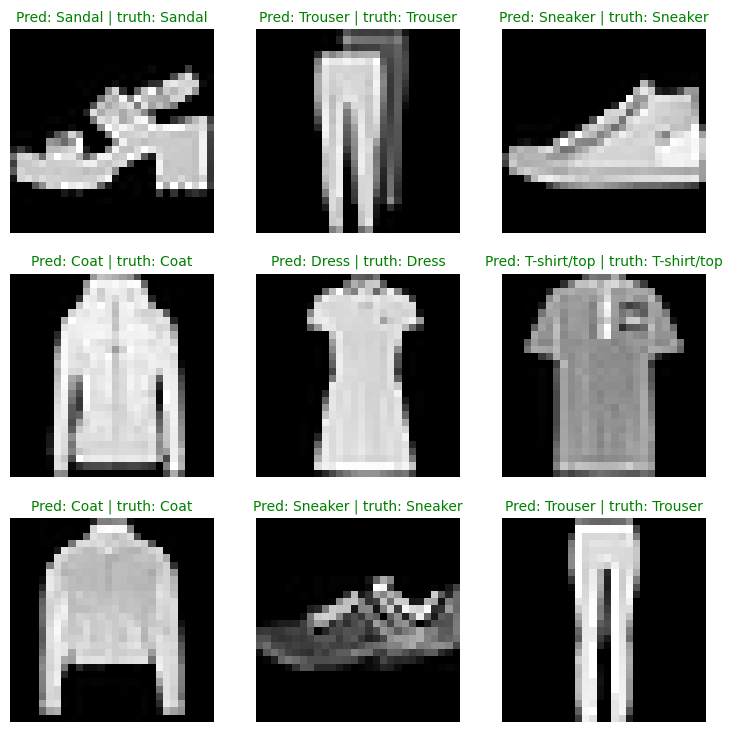

In [147]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows, ncols = 3, 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title_text = f"Pred: {pred_label} | truth: {truth_label}"
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation

1. Make predictions with iyt trained model on the test dataset
2. Make a confusion matrix: `torchmetrics`.
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [151]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    y_preds.append(y_pred.cpu())

  # Concatenate list of predictions into a tensor
  # print(y_preds)
  y_pred_tensor = torch.cat(y_preds)
  y_pred_tensor[0]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [152]:
len(y_pred_tensor)

10000

In [ ]:
# See if required packages are install and if not, install them

In [155]:
try:
  import mlxtend, torchmetrics
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 74.0 MB/s eta 0:00:00
mlxtend version: 0.22.0


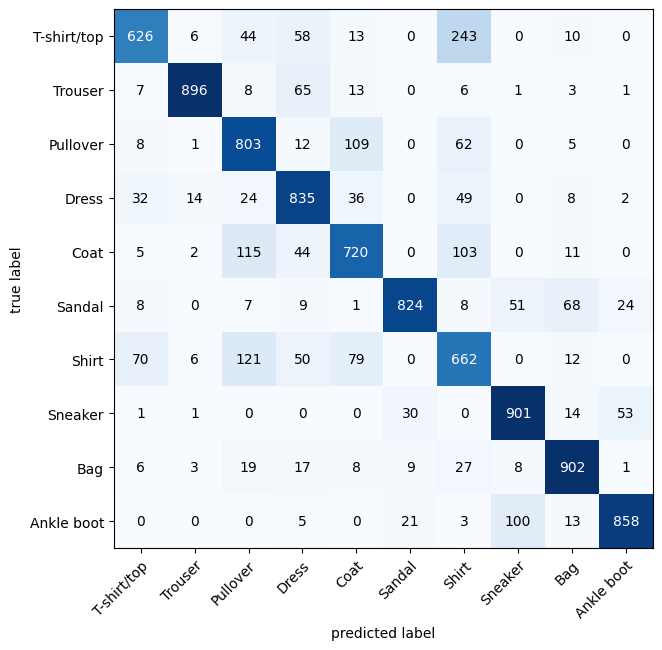

In [165]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

## 11. Save and load the best performing model

In [166]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [168]:
# Create a new instance
torch.manual_seed(42)
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))
# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [169]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.31588950753211975,
 'model_acc': 88.70806709265176}

In [172]:
# # Evaluate loaded model
# torch.manual_seed(42)

# loaded_model_2_results = eval_model(
#     model=loaded_model_2,
#     data_loader=test_dataloader,
#     loss_fn=loss_fn,
#     accuracy_fn=accuracy_fn
# )

# loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor